In [2]:
import requests
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Import Data from API

Data comes in as a complex JSON file. Make python just... turn it into a dataframe for me. 

In [3]:
response_API = requests.get('https://maps2.dcgis.dc.gov/dcgis/rest/services/FEEDS/MPD/MapServer/5/query?outFields=*&where=1%3D1&f=geojson')
# print(response_API.status_code)
data = response_API.text
parse_json = json.loads(data)
df = pd.json_normalize(parse_json, record_path = ['features'])
df.set_index('id',inplace=True)

Pretty up column headers, drop unused columns to make table simpler to use going forward. 

In [4]:
column_heads = {
    'type': 'type',
    'geometry.type': 'GEO_TYPE',
    'geometry.coordinates': 'COORDINATES',
    'properties.SHIFT': 'SHIFT',
    'properties.METHOD': 'METHOD',
    'properties.OFFENSE': 'OFFENSE',
    'properties.BLOCK': 'BLOCK',
    'properties.XBLOCK': 'XBLOCK',
    'properties.YBLOCK': 'YBLOCK',
    'properties.WARD': 'WARD',
    'properties.ANC': 'ANC',
    'properties.DISTRICT': 'DISTRICT',
    'properties.PSA': 'PSA',
    'properties.NEIGHBORHOOD_CLUSTER': 'NEIGHBORHOOD_CLUSTER',
    'properties.BLOCK_GROUP': 'BLOCK_GROUP',
    'properties.CENSUS_TRACT': 'CENSUS_TRACT',
    'properties.VOTING_PRECINCT': 'VOTING_PRECINCT',
    'properties.LATITUDE': 'LATITUDE',
    'properties.LONGITUDE': 'LONGITUDE',
    'properties.BID': 'BID',
    'properties.REPORT_DAT': 'REPORT_DATE',
    'properties.START_DATE': 'START_DATE',
    'properties.END_DATE': 'END_DATE',
}

df.rename(column_heads,axis='columns',inplace=True)
df['REPORT_DATE']=pd.to_datetime(df['REPORT_DATE'],origin='unix',unit='ms')
df['START_DATE'] = pd.to_datetime(df['START_DATE'],origin='unix',unit='ms')
df['END_DATE'] = pd.to_datetime(df['END_DATE'],origin='unix',unit='ms')
df = df.drop(['properties.CCN','type','properties.OBJECTID','properties.OCTO_RECORD_ID'],axis=1)

Poke around in dataframe and check out interesting combinations of factors. 

In [5]:
print(df.value_counts(subset=['SHIFT','METHOD']))

SHIFT     METHOD
DAY       OTHERS    423
EVENING   OTHERS    316
MIDNIGHT  OTHERS    187
EVENING   GUN        25
MIDNIGHT  GUN        24
DAY       GUN        13
EVENING   KNIFE       7
MIDNIGHT  KNIFE       4
DAY       KNIFE       1
dtype: int64


## Dataframe Subsets for Analysis

Build any number of interesting manipulated dataframes and summaries to start describing the data and get to the functionality we're looking for. 

In [6]:
df_sub = df.sample(n=4)
#print(df_sub)

df_change = df[df["SHIFT"].shift() != df["SHIFT"]]
#print(df_change)


df_offenses = df.groupby(['OFFENSE','METHOD']).count()
df_offenses = df_offenses['PSA']
print(df_offenses)

offenses_pivot = pd.pivot_table(
    df,
    values="XBLOCK",
    index="METHOD",
    columns="OFFENSE",
    aggfunc=np.count_nonzero
)
offenses_pivot

OFFENSE                     METHOD
ARSON                       OTHERS      1
ASSAULT W/DANGEROUS WEAPON  GUN        26
                            KNIFE       7
                            OTHERS      3
BURGLARY                    OTHERS     24
HOMICIDE                    GUN         5
                            OTHERS      2
MOTOR VEHICLE THEFT         OTHERS    193
ROBBERY                     GUN        31
                            KNIFE       4
                            OTHERS     30
SEX ABUSE                   OTHERS      3
THEFT F/AUTO                OTHERS    290
THEFT/OTHER                 KNIFE       1
                            OTHERS    379
Name: PSA, dtype: int64


OFFENSE,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER
METHOD,,,,,,,,,
GUN,NaN,26.0,NaN,5.0,NaN,31.0,NaN,NaN,NaN
KNIFE,NaN,7.0,NaN,NaN,NaN,4.0,NaN,NaN,1.0
OTHERS,1.0,3.0,24.0,2.0,193.0,30.0,3.0,290.0,380.0


## Plotting Dataframes

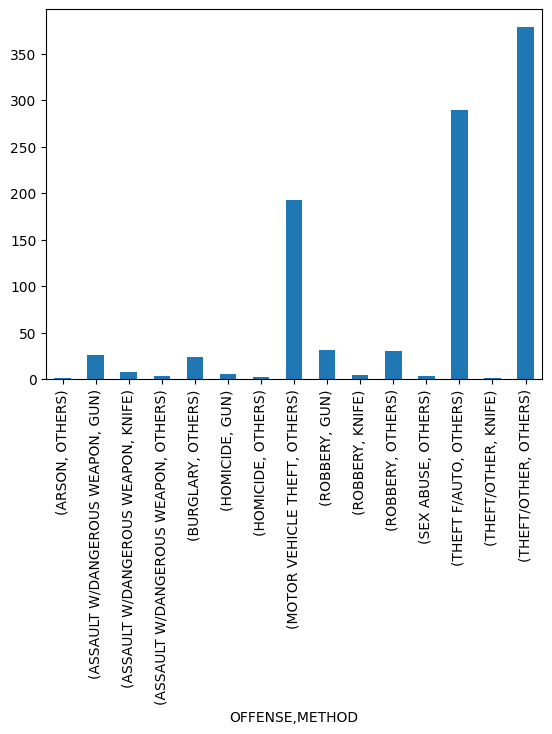

Text(0, 0.5, 'Average Page Views')

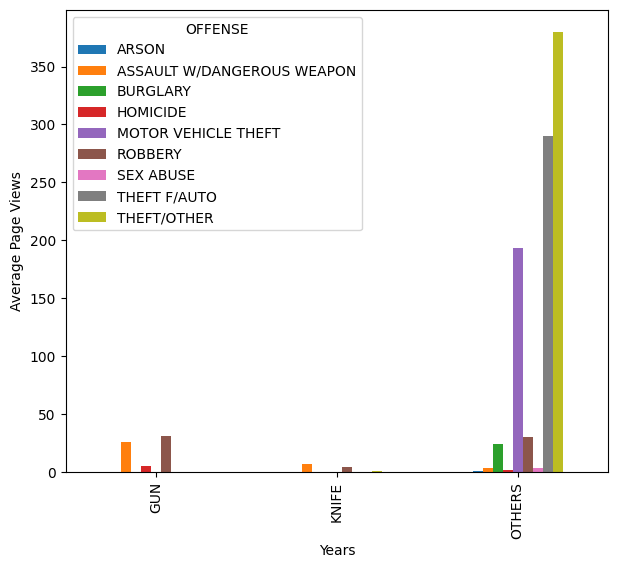

In [7]:
df_offenses.plot.bar(stacked=True)
plt.show()

# Plot a bar chart using the DF
ax = offenses_pivot.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Years")
ax.set_ylabel("Average Page Views")